# Predicting Sin and Cos

첫번째것과 동일한데 input의 time magnitude와 output의 time magnitude를 예측할때의 기법

In [1]:
%pylab inline
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data

pad_sequences를 해줍으로서 시계열 데이터를 원하는 output싸이즈로 맞춰주며, 앞부분을 전부 0으로 만들어 줍니다.

```
>> pad_sequences(np.array([[[1],[2],[3]], [[4], [5], [6]]]), maxlen=10)
array([[[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [2],
        [3]],

       [[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [4],
        [5],
        [6]]], dtype=int32)
```


x: (3000, 500, 1)
y: (3000, 500, 1)
test x: (3000, 500, 1)
test y: (3000, 500, 1)


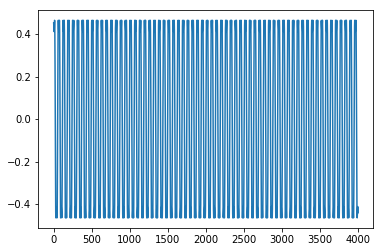

In [19]:
SIZE_X = 500
SIZE_Y = 50

data = np.arange(-200, 200, 0.1)
data = np.sin(data)
data = np.cos(data)* np.tanh(data)


def make_x_y(data, size_x=100, size_y=500):
    N = data.shape[0]
    
    data_x = np.zeros((N-size_x*2, size_x))
    data_y = np.zeros((N-size_x*2, size_y))
    test_x = np.zeros((N-size_x*2, size_x))
    test_y = np.zeros((N-size_x*2, size_x))
    
    for i, idx in enumerate(range(0, N-size_x*2)):
        x = data[idx: idx+size_x]
        y = data[idx+size_x: (idx+size_x) + size_y]
        
        data_x[idx, :size_x] = x
        data_y[idx, :size_y] = y
        test_x[idx, :size_x] = data[idx: idx+size_x]
        test_y[idx, :size_x] = data[idx+size_x: (idx+size_x) + size_x]
        
    data_x = np.asarray(data_x)
    data_y = np.asarray(data_y)
    
    
    data_x = data_x.reshape(-1, size_x, 1)
    data_y = data_y.reshape(-1, size_y, 1)
    test_x = test_x.reshape(-1, size_x, 1)
    test_y = test_y.reshape(-1, size_x, 1)
    
    # POINT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    data_y = pad_sequences(data_y, maxlen=size_x, padding='post', dtype='float32')
        
    # Shuffle
    permu = np.random.permutation(data_x.shape[0])
    data_x = data_x[permu]
    data_y = data_y[permu]
    return data_x, data_y, test_x, test_y


x, y, test_x, test_y = make_x_y(data, size_x=SIZE_X, size_y=SIZE_Y)
print('x:', x.shape)
print('y:', y.shape)
print('test x:', test_x.shape)
print('test y:', test_y.shape)

plot(data)

### Visualize training data 

x값과 y값을 한번에 합쳐서 보여줍니다.<br> 
대충 중간에 선이 있다고 생각하면 됩니다. 왼쪽은 x값 오른쪽은 y값


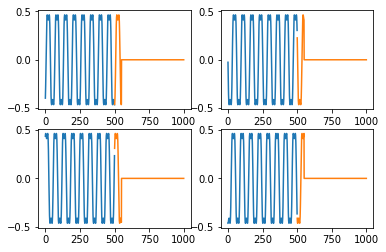

In [18]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
#             sp.get_xaxis().set_visible(False)
#             sp.get_yaxis().set_visible(False)
            
            r = np.random.randint(data_x.shape[0])
            sample_x = data_x[r]
            sample_y = data_y[r]
            
            
            sample_x = sample_x.reshape(sample_x.shape[0])
            sample_y = sample_y.reshape(sample_y.shape[0])
            
            
            tick_x = range(0, SIZE_X)
            tick_y = range(SIZE_X, SIZE_X+SIZE_X)
            
            sp.plot(tick_x, sample_x)
            sp.plot(tick_y, sample_y)

visualize(x, y)

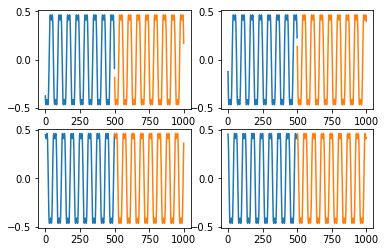

In [14]:
visualize(test_x, test_y)

## Model

/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(None, Non..., return_sequences=True, units=10)`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="fully_connected_layer01", units=10)`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="fully_connected_layer02", units=1)`
  '` call to the Keras 2 API: ' + signature)


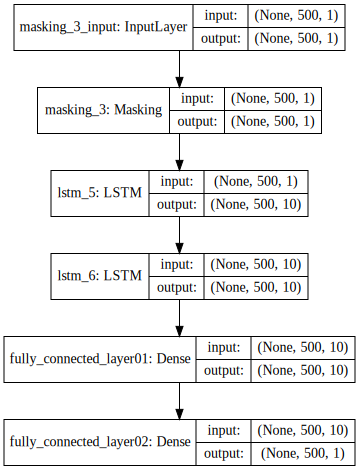

In [22]:
def create_model(lstm_out=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(Masking(mask_value=0, batch_input_shape=(None, SIZE_X, 1)))
    model.add(LSTM(batch_input_shape=(None, None, 1), output_dim=lstm_out, return_sequences=True))
    model.add(LSTM(batch_input_shape=(None, None, 1), output_dim=lstm_out, return_sequences=True))
    model.add(Dense(output_dim=10, name='fully_connected_layer01'))
    model.add(Dense(output_dim=1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [16]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, SIZE_Y))
    y_pred = y_pred.reshape((-1, SIZE_Y))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


# Grid Search 
params = dict(lstm_out=[1, 10, 20, 30, 40, 300], 
              optimizer=['adam'], 
              nb_epoch=[5])

classifier = KerasClassifier(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer)
grid_result = grid.fit(x, y)

/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(None, Non..., return_sequences=True, units=1)`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="fully_connected_layer01", units=10)`
  '` call to the Keras 2 API: ' + signature)
/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(name="fully_connected_layer02", units=1)`
  '` call to the Keras 2 API: ' + signature)


ValueError: Error when checking model input: expected masking_2_input to have shape (None, 100, 1) but got array with shape (2000, 500, 1)

In [ ]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

## Train

In [23]:
params = dict(lstm_out=10,
              optimizer='adam')


print(x.shape, y.shape)

# model = create_model(**params)
model.fit(x, y, verbose=2, epochs=5)

(3000, 500, 1) (3000, 500, 1)
Epoch 1/60
62s - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 2/60
62s - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 3/60
62s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 4/60
61s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/60
57s - loss: 8.4970e-04 - mean_squared_error: 8.4970e-04
Epoch 6/60
59s - loss: 7.5816e-04 - mean_squared_error: 7.5816e-04
Epoch 7/60
60s - loss: 7.0062e-04 - mean_squared_error: 7.0062e-04
Epoch 8/60


KeyboardInterrupt: 

error:0.0006889895885251462, score:0.9610176934270447
Mean Squared Error: 0.961017693427


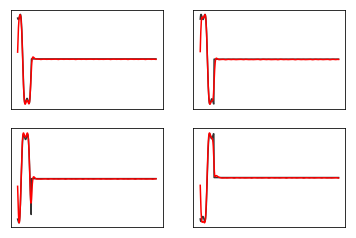

In [26]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, SIZE_X))
    y_pred = y_pred.reshape((-1, SIZE_X))
    
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score

def visualize_prediction(data_x, data_y):   
    data_p = model.predict(data_x)
    
    data_x = data_x.reshape((-1, SIZE_X))
    data_y = data_y.reshape((-1, SIZE_X))
    data_p = data_p.reshape((-1, SIZE_X))
    
    print('Mean Squared Error:', accuracy(data_y, data_p))
    
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
        
            idx = np.random.randint(data_x.shape[0])
            
#             sp.plot(data_x[idx], color='blue')
            sp.plot(data_y[idx], color='#333333')
            sp.plot(data_p[idx], color='red')


visualize_prediction(x, y)